# CS4035 - Cyber Data Analytics
## Lab 4

### Submit on brightspace (zip file with the name Group_xx.zip)
This jupyter file completed with code, plots, figures and report for each question. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.

(if you used hard-to-get libraries) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number :

## Student 1 
### Name :
### ID :

## Student 2
### Name :
### ID :

## README

Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.neural_network import MLPClassifier
import pandas as pd
from sklearn.metrics import confusion_matrix

# dataset folder path
path = "cda_lab4_data_2022/"

In [57]:
def print_metrics(y_true, y_pred, text):
    print(f"Results for {text}\n")
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    evasion_rate = fn/(fn+tp)
    print(f"Accuracy | TN | FP | FN | TP")
    print(f"{accuracy:.4f} | {tn} | {fp} | {fn} | {tp}")
    print("\nEvasion rate:", evasion_rate, "\n")

## 1. Preparation (0 points)

### 1a. Load the dataset and split it into a train and test set

In [80]:
data = np.load(path + "X.npy")
label = np.load(path + "y.npy")
print("shape of data: ",data.shape)
print("shape of label: ",label.shape)

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

slice_index = 1000
X_train = X_train[:slice_index]
X_test = X_test[:slice_index]
y_train = y_train[:slice_index]
y_test = y_test[:slice_index]

shape of data:  (30396, 22761)
shape of label:  (30396,)


## 2. Attacking linear models (5 Points)

### 2a. Implementing useless import attacks


In [95]:
model = SGDClassifier(loss='log_loss', random_state = 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred, "non-evaded test set")

Results for non-evaded test set

Accuracy | TN | FP | FN | TP
0.9010 | 414 | 77 | 22 | 487

Evasion rate: 0.043222003929273084 



In [6]:
# n_libraries takes the number of useless libraries to be imported

def evade(sample, coef, n_libraries=10):
    library_indices = np.where(sample == 1)[0].tolist()
    neg_coef = np.random.permutation(np.where(coef[0] <  0))[0]
    sample_neg_coef = np.random.choice(neg_coef, n_libraries)
    library_indices.extend(sample_neg_coef.tolist())
    
    new_row = np.zeros(coef.shape[1])
    new_row[library_indices] = 1

    return new_row

In [96]:
# find out the optimal number of useless libraries to be imported

malicious_samples = X_train[np.where(y_train == 1)]
coefficients = model.coef_

changes = []
for n in tqmd(range(10, 300, 10)):
    changed_prediction = 0
    for sample in malicious_samples:
        prediction  = model.predict([sample])[0]
        new_data = evade(sample, coefficients, n_libraries=n)
        evaded_prediction = model.predict([new_data])[0]
        changed_prediction += evaded_prediction != prediction
    changes.append(changed_prediction/len(malicious_samples))

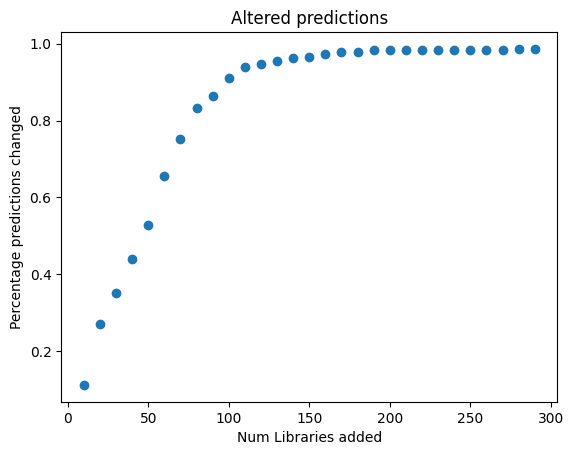

In [97]:
plt.plot(range(10, 300, 10), changes, 'o')
plt.title("Altered predictions")
plt.xlabel("Num Libraries added")
plt.ylabel("Percentage predictions changed")
plt.show()

Based on the plot above we can say with around 250 imported libraries, we can changed the most rows that are detected as malicious. 

In [109]:
def get_evaded_data(data, label=None, only_malicious=False, added_libraries=250, coefs=None):
    new_data = []
    if only_malicious:
        for index, sample in enumerate(data):
            if label[index] == 1:
                evaded_sample = evade(sample, coefficients, n_libraries=added_libraries)
                new_data.append(evaded_sample)
            else:
                new_data.append(sample)
    else:
        for index, sample in enumerate(data):
            evaded_sample = evade(sample, coefficients, n_libraries=added_libraries)
            new_data.append(evaded_sample)
    return new_data

In [82]:
# evade the whole test set or only malicious ones
X_test_evaded_whole = get_evaded_data(X_test)
X_test_evaded_part = get_evaded_data(X_test, y_test, only_malicious=True)

y_pred_whole = model.predict(X_test_evaded_whole)
y_pred_part = model.predict(X_test_evaded_part)

print_metrics(y_test, y_pred_whole, "evaded the whole test set")
print_metrics(y_test, y_pred, "evaded test set only for malicious rows")

Results for evaded test set

Accuracy | TN | FP | FN | TP
0.4450 | 425 | 66 | 489 | 20

Evasion rate: 0.9607072691552063 



### 2b. Analysis and answers to the questions

- We can observe that before applying attacks to the test test, the model has a high accuracy of about 0.9. However, the number reduces to only 0.45 when the test set is evaded, which shows that the model is not robust to useless imports attacks. Additionaly, looking at the evasion rates, we can see that most (0.96) attacks can not be detected by the model. 

- The reason can be explained by the fact that the model has never seen similar samples during training before, and during evasion, we added libraries that are usually seen in benign cases, which tricks our model.


## 3. Improving robustness by hardening (5 Points)

### 3a. Implementing hardening

In [115]:
# split into batches
batch_size = 128

X_train_batch = np.array_split(X_train, len(X_train_evaded)//batch_size)
y_train_batch = np.array_split(y_train, len(y_train)//batch_size)

# training the model with evaded data
model_hardened = SGDClassifier(loss='log_loss', random_state=42)
model_hardened.partial_fit(X_train_batch[0], y_train_batch[0], classes=np.unique(y_train))

for x, y in zip(X_train_batch, y_train_batch):
    evaded_batch = get_evaded_data(x, y, only_malicious = True, coefs=model_hardened.coef_)
    model_hardened.partial_fit(evaded_batch, y, classes=np.unique(y_train))

y_pred_evaded = model_hardened.predict(X_test_evaded)
y_pred_origin = model_hardened.predict(X_test)

print_metrics(y_test, y_pred_evaded, "evaded test set on hardened model")
print("")
print_metrics(y_test, y_pred_origin, "non-evaded test set on hardened model")


Results for evaded test set on hardened model

Accuracy | TN | FP | FN | TP
0.9140 | 405 | 86 | 0 | 509

Evasion rate: 0.0 


Results for non-evaded test set on hardened model

Accuracy | TN | FP | FN | TP
0.8140 | 405 | 86 | 100 | 409

Evasion rate: 0.19646365422396855 



In [77]:
batch_sizes = [16, 32, 64, 128, 256]

batch_accuracies = []

# applying evasion attacks to the train batches 
for batch_size in tqdm(batch_sizes):
    X_train_evaded = []

    for sample in X_train:
        evaded_sample = evade(sample, coefficients, n_libraries=250)
        X_train_evaded.append(evaded_sample)

    # split into batches
    X_train_evaded_batch = np.array_split(X_train_evaded, len(X_train_evaded)//batch_size)
    y_train_batch = np.array_split(y_train, len(y_train)//batch_size)

    # training the model with evaded data
    model_hardened = SGDClassifier(loss='log_loss', random_state=42)

    accuracies_evaded = []
    accuracies_origin = []
    for x, y in zip(X_train_evaded_batch, y_train_batch):
        model_hardened.partial_fit(x, y, classes=np.unique(y_train))

        y_pred_evaded = model_hardened.predict(X_test_evaded)
        accuracy = accuracy_score(y_test, y_pred_evaded)
        accuracies_evaded .append(accuracy)

        y_pred_origin = model_hardened.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_origin)
        accuracies_origin.append(accuracy)
    batch_accuracies.append((accuracies_origin, accuracies_evaded))
    

  0%|          | 0/5 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x000002675DBFA0E0>
Traceback (most recent call last):
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\notebook.py", line 276, in close
    def close(self):
KeyboardInterrupt: 


ValueError: Found input variables with inconsistent numbers of samples: [1500, 2500]

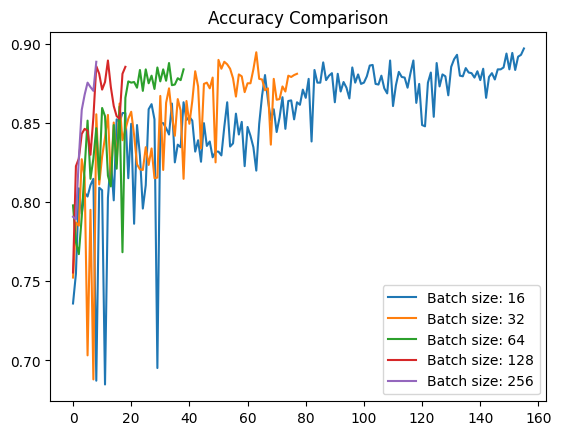

In [14]:
for i in range(len(batch_accuracies)):
    accuracies_evaded, _ = batch_accuracies[i]
    plt.plot(range(len(accuracies_evaded)), accuracies_evaded, label=f'Batch size: {batch_sizes[i]}')
plt.legend()  
plt.title('Accuracy Comparison') 
plt.show()  

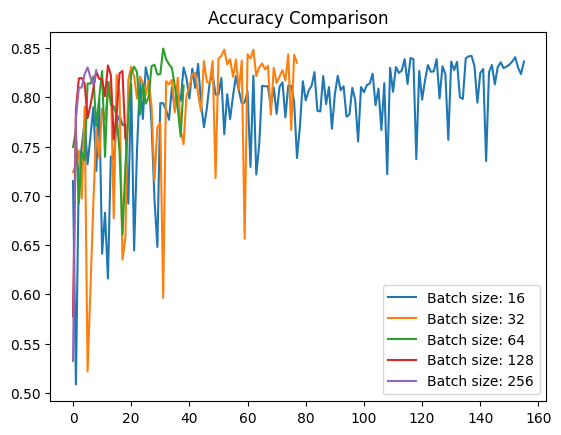

In [15]:
for i in range(len(batch_accuracies)):
    _, accuracies_origin = batch_accuracies[i]
    plt.plot(range(len(accuracies_origin)), accuracies_origin, label=f'Batch size: {batch_sizes[i]}')
plt.legend()
plt.title('Accuracy Comparison')
plt.show()  

### 3b. Analysis and answers to the questions

- After hardening our model by training on evaded training batches, we observe that our model is able to identify attacked rows 100% of the time(evasion rate = 0), which shows its robustness. However, the hardened model performs worse by 0.1 in terms of accuracy on the non-evaded test data set.
- This can be explained by the fact that during training, the model also encounters many malicious samples containing added libraries that are usually included by benign rows. Also, becasue the model now assumes some cases where the row contains many benign libraries as being malicious, which leads to more false negatives and a lower accuracy overall.

## 4. Training non-negative linear models (5 Points)

### 4a. Implement non-negative logistic regression using SGD

In [118]:
batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512]

accuracies_evaded = []
evasion_rates = []

for batch_size in tqdm(batch_sizes):
    model_non_negative = SGDClassifier(loss='log_loss', random_state=42)

    y_train_batch = np.array_split(y_train, len(y_train)//batch_size)
    X_train_batch = np.array_split(X_train, len(X_train)//batch_size)
    accuracies = []
    for x, y in tqdm(zip(X_train_batch, y_train_batch)):
        model_non_negative.partial_fit(x, y, classes=np.unique(y_train))
        model_non_negative.coef_[model_non_negative.coef_ < 0] = 0
    
        y_pred_evaded = model_non_negative.predict(X_test_evaded)
        accuracy = accuracy_score(y_test, y_pred_evaded)
        accuracies.append(accuracy)
    accuracies_evaded.append(accuracies)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_evaded).ravel()
    evasion_rate = fn/(fn+tp)
    evasion_rates.append(evasion_rate)

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

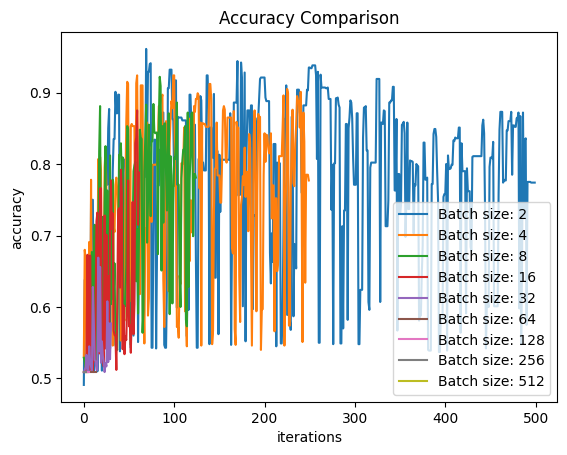

In [119]:
for i in range(len(batch_sizes)):
    accuracy_evaded = accuracies_evaded[i]
    plt.plot(range(len(accuracy_evaded)), accuracy_evaded, label=f'Batch size: {batch_sizes[i]}')
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.legend()  
plt.title('Accuracy Comparison') 
plt.show()  

Text(0.5, 0, 'Batch Size')

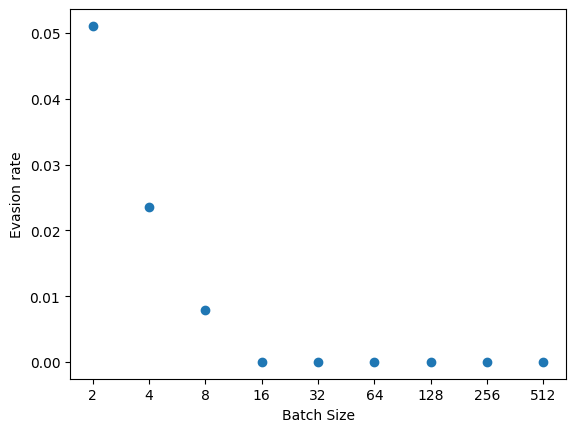

In [120]:
plt.plot(range(len(batch_sizes)), evasion_rates,'o')
plt.xticks(range(len(batch_sizes)), [str(x) for x in batch_sizes])
plt.ylabel("Evasion rate")
plt.xlabel("Batch Size")

With increasing batch_size, our model is becoming more robust against useless library import attacks, and we then chose 16 as the best batch_size. 

In [124]:
best_batch_size = 16
model_non_negative = SGDClassifier(loss='log_loss', random_state=42)
y_train_batch = np.array_split(y_train, len(y_train)//best_batch_size)
X_train_batch = np.array_split(X_train, len(X_train)//best_batch_size)
for x, y in tqdm(zip(X_train_batch, y_train_batch)):
    model_non_negative.partial_fit(x, y, classes=np.unique(y_train))
    model_non_negative.coef_[model_non_negative.coef_ < 0] = 0

0it [00:00, ?it/s]

In [125]:
y_pred_evaded = model_non_negative.predict(X_test_evaded)
print_metrics(y_test, y_pred_evaded, "non-evaded test set on hardened model")

Results for non-evaded test set on hardened model

Accuracy | TN | FP | FN | TP
0.7880 | 279 | 212 | 0 | 509

Evasion rate: 0.0 



In [126]:
y_pred = model_non_negative.predict(X_test)
print_metrics(y_test, y_pred, "non-evaded test set on hardened model")

Results for non-evaded test set on hardened model

Accuracy | TN | FP | FN | TP
0.7190 | 279 | 212 | 69 | 440

Evasion rate: 0.13555992141453832 



# 4b. Analysis and answers to the questions.

- After clipping the coefficients of the model to non-negative values after every batch, we observe that our model is able to identify attacked rows 100% of the time(evasion rate = 0), which shows its robustness. However, the non-negative coefficient model performs worse by 0.07 in terms of accuracy on the non-evaded test data set. 

- Additionaly, the model is more robust than the first model but it is worse than the hardened one.

## 5. Bonus

In [71]:
batch_size = 4

y_train_batch = np.array_split(y_train, len(y_train)//batch_size)
X_train_batch = np.array_split(X_train, len(X_train)//batch_size)

model_nn = MLPClassifier()
for x, y in tqdm(zip(X_train_batch, y_train_batch)):
    model_nn.partial_fit(x, y, classes=np.unique(y_train))
    for i in range(len(model_nn.coefs_)):
        model_nn.coefs_[i] = np.clip(model_nn.coefs_[i], 0, np.inf)
            
y_pred_evaded = model_nn.predict(X_test_evaded)
y_pred = model_nn.predict(X_test)

print_metrics(y_test, y_pred,"non-evaded on Neural Network model")
print("")
print_metrics(y_test, y_pred_evaded,"evaded on Neural Network model")

0it [00:00, ?it/s]

Results for non-evaded on Neural Network model

Accuracy | TN | FP | FN | TP
0.8192 | 1059 | 170 | 282 | 989

Evasion rate: 0.2218725413060582 


Results for evaded on Neural Network model

Accuracy | TN | FP | FN | TP
0.9172 | 1059 | 170 | 37 | 1234

Evasion rate: 0.029110936270653028 



In [73]:
results = []
for test in tqdm(pd.read_csv("test.csv", chunksize = 1024,iterator = True)):
#     print(test.head())
    test.drop(test.columns[0],inplace = True, axis = 1)
#     result = model_hardened.predict(test)
#     result = model_non_negative.predict(test)
    result = model_nn.predict(test)
    results.extend(result)


0it [00:00, ?it/s]

C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MLPClassifier was fitted without feature nam

In [66]:
result_df = pd.DataFrame({'Id':range(len(results)),'Prediction':results})
result_df.to_csv("result4.csv",index = False)

### 5c. Evaluate the robustness of the two models